In [63]:
import kagglehub
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dython
from optuna import trial
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [64]:
path = kagglehub.dataset_download("arashnic/dynamic-pricing-dataset")
src = pd.read_csv(os.path.join(path, "dynamic_pricing.csv"))
src.rename(columns={
    'Number_of_Riders': 'Riders',
    'Number_of_Drivers': 'Drivers',
    'Location_Category': 'Location',
    'Customer_Loyalty_Status': 'Loyalty',
    'Number_of_Past_Rides': 'PastRides',
    'Average_Ratings': 'Ratings',
    'Time_of_Booking': 'BookingTime',
    'Vehicle_Type': 'Vehicle',
    'Expected_Ride_Duration': 'Duration',
    'Historical_Cost_of_Ride': 'Cost'
}, inplace=True)

In [65]:
print(f"Dataset info:\n"
      f"shape: \n{src.shape}\n"
      f"null values: \n{src.isnull().sum()}\n"
      f"dtypes: \n{src.dtypes}")


Dataset info:
shape: 
(1000, 10)
null values: 
Riders         0
Drivers        0
Location       0
Loyalty        0
PastRides      0
Ratings        0
BookingTime    0
Vehicle        0
Duration       0
Cost           0
dtype: int64
dtypes: 
Riders           int64
Drivers          int64
Location        object
Loyalty         object
PastRides        int64
Ratings        float64
BookingTime     object
Vehicle         object
Duration         int64
Cost           float64
dtype: object


OK, so 1000 entries, no null values. Good.
But Number of Drivers and Riders separately doesn't give us any info.
Let's combine them by creating ratio.

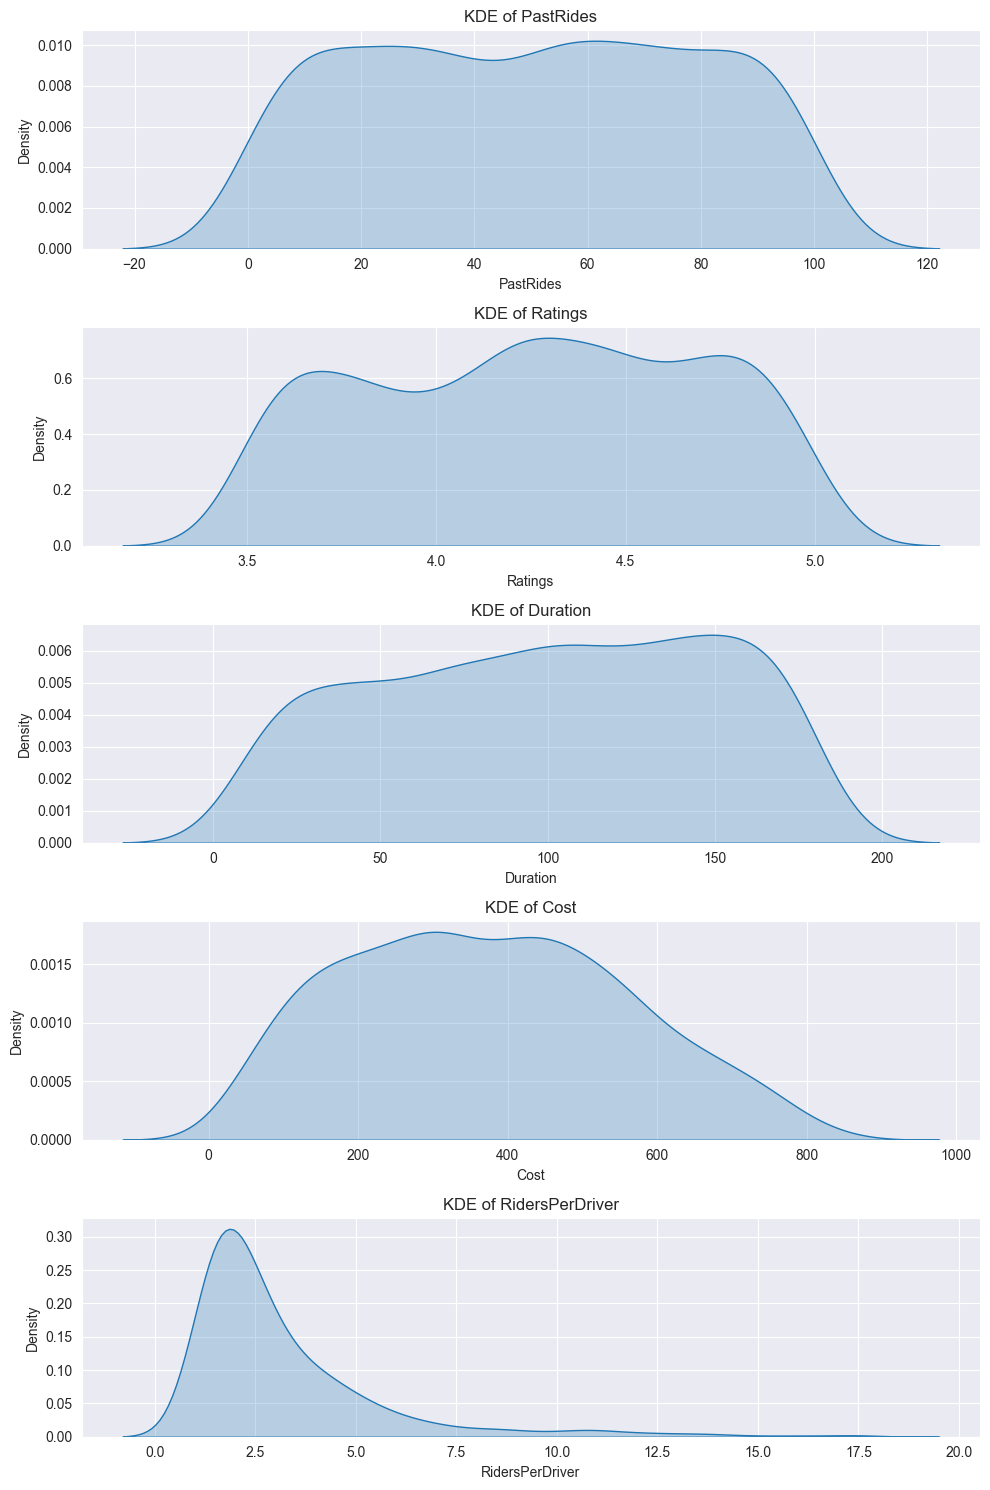

In [66]:
src['RidersPerDriver'] = pd.DataFrame(src['Riders'] / src['Drivers'],
                                      columns=['RidersPerDriver'])
src.drop(columns=['Riders', 'Drivers'], inplace=True)

# Let's see distributions of numerical columns. We'll use KDE plots for this.
numerical_columns = src.select_dtypes(include=['float64', 'int']).columns
# Create subplots
fig, axes = plt.subplots(nrows=len(numerical_columns), ncols=1, figsize=(10, 15))
for col, ax in zip(numerical_columns, axes):
    sns.kdeplot(data=src, x=col, ax=ax, fill=True)
    ax.set_title(f'KDE of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Density')
# Adjusting layout to prevent overlap
plt.tight_layout()
plt.show()

so looks like RidesPerDriver is skewed a lot and seems to have outliers (z>3).
We'll remove those outliers.

In [67]:
from scipy.stats import zscore

# Calculate the z-scores of all numerical columns except the target variable
z_scores = np.abs(src.select_dtypes(include=[np.number]).apply(zscore))

# Define a threshold and filter the dataset
threshold = 3
src = src[(z_scores < threshold).all(axis=1)]

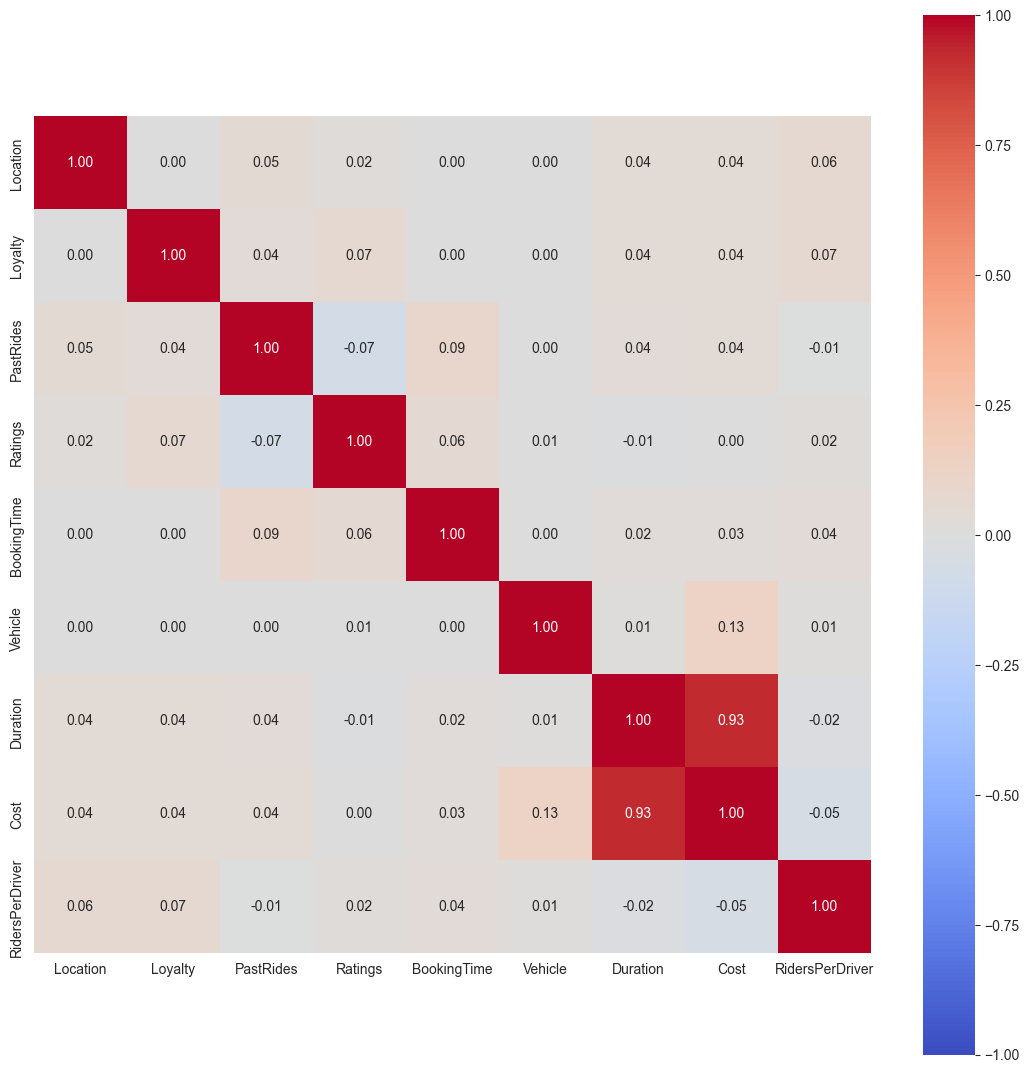

{'corr':                  Location   Loyalty  PastRides   Ratings  BookingTime  \
 Location         1.000000  0.000000   0.047468  0.018015     0.000000   
 Loyalty          0.000000  1.000000   0.038148  0.066283     0.000000   
 PastRides        0.047468  0.038148   1.000000 -0.070400     0.089434   
 Ratings          0.018015  0.066283  -0.070400  1.000000     0.055867   
 BookingTime      0.000000  0.000000   0.089434  0.055867     1.000000   
 Vehicle          0.000000  0.000000   0.003894  0.005688     0.000000   
 Duration         0.041868  0.042258   0.035456 -0.013198     0.024288   
 Cost             0.043480  0.041241   0.040358  0.002255     0.030143   
 RidersPerDriver  0.063064  0.067027  -0.007722  0.020764     0.036116   
 
                   Vehicle  Duration      Cost  RidersPerDriver  
 Location         0.000000  0.041868  0.043480         0.063064  
 Loyalty          0.000000  0.042258  0.041241         0.067027  
 PastRides        0.003894  0.035456  0.040358      

In [68]:
# Time for correlation plot. Since we have mix of numerical and categorical variables,
# standard data.corr() won't work here. We will use dython.nominal.associations instead.
dython.nominal.associations(src, plot=True, cmap='coolwarm')

In [69]:
# Duration and Cost have very high correlation (0.93). We will do PCA on these components.
scaler = StandardScaler()
src[['Duration', 'Cost']] = scaler.fit_transform(src[['Duration', 'Cost']])
pca = PCA(n_components=1)
pca_results = pca.fit_transform(src[['Duration', 'Cost']])
src.drop(columns=['Duration', 'Cost'], inplace=True)
src['DurationCostPCA'] = pca_results[:, 0]

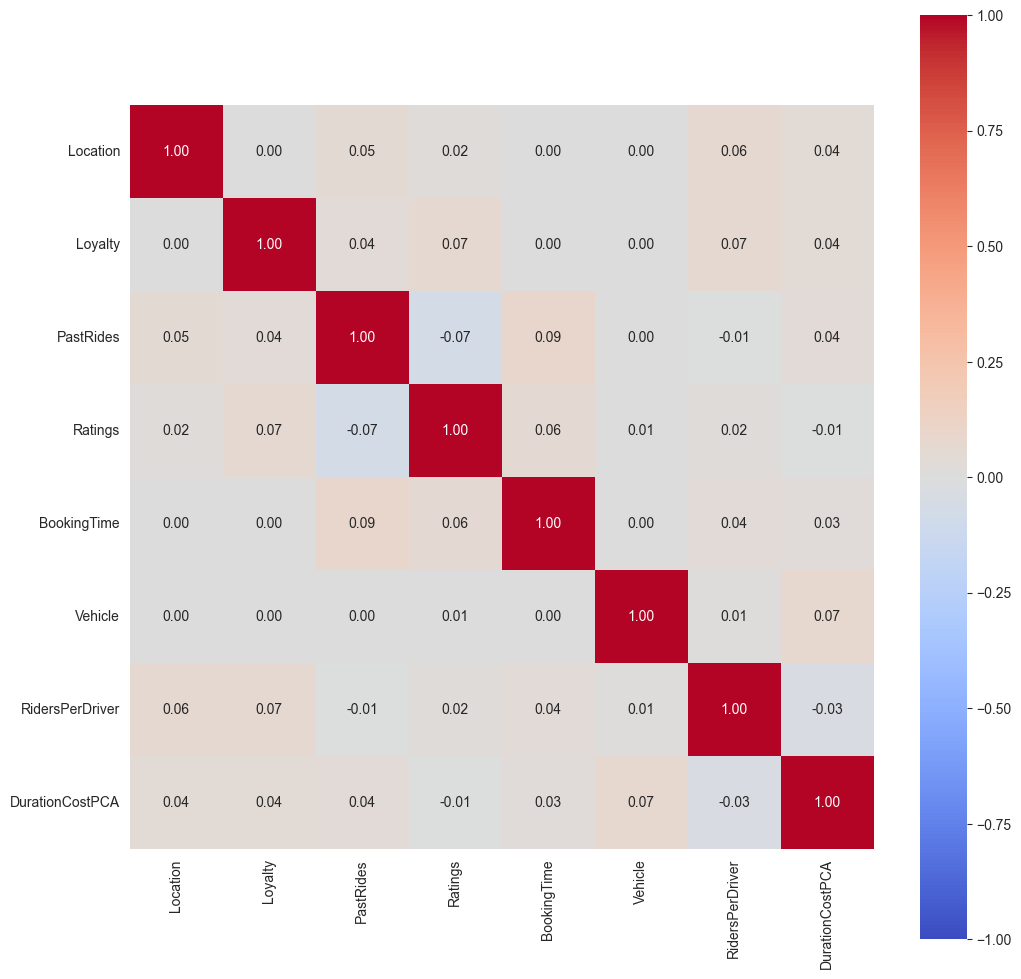

In [70]:
dython.nominal.associations(src, plot=True, cmap='coolwarm')
plt.show()

In [71]:
src['Loyalty'] = src['Loyalty'].map({
    'Regular': -1,
    'Silver': 0,
    'Gold': 1
}).astype(int)

In [72]:
label_encoder = LabelEncoder()
categorical_columns = src.select_dtypes(include=['object']).columns.values
for col in categorical_columns:
    src[col] = LabelEncoder().fit_transform(src[col])

In [73]:
import xgboost

In [74]:
xgb_model = xgboost.XGBRegressor()
feature_names = np.array(src.drop(columns=['DurationCostPCA']).columns)
X = src.drop(columns=['DurationCostPCA']).to_numpy()
y = src['DurationCostPCA'].to_numpy()
xgb_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [75]:
predictions = xgb_model.predict(X)
score = xgb_model.score(X, y)
print(score)
print(predictions.)
for name, importance in zip(feature_names, xgb_model.feature_importances_):
    print(f'Feature: {name}, Importance: {importance}')

0.9824990679096572
Feature: Location, Importance: 0.07226848602294922
Feature: Loyalty, Importance: 0.08927790820598602
Feature: PastRides, Importance: 0.15531817078590393
Feature: Ratings, Importance: 0.15604954957962036
Feature: BookingTime, Importance: 0.16795989871025085
Feature: Vehicle, Importance: 0.18158820271492004
Feature: RidersPerDriver, Importance: 0.17753782868385315


In [83]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predict the target values
predictions = xgb_model.predict(X)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y, predictions))
print(rmse)

0.18366190219028852


In [76]:
import optuna
from optuna.pruners import HyperbandPruner
def objective(trial: optuna.Trial) -> float:
    params = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
    }

    # DMatrix for Cross Validation
    dtrain = xgboost.DMatrix(X, label=y)

    # Perform cross-validation
    cv_results = xgboost.cv(
        params,
        dtrain,
        num_boost_round=1000,
        nfold=5,
        early_stopping_rounds=50,
        metrics="rmse",
        seed=42
    )

    # Extract the best score
    best_rmse = cv_results['test-rmse-mean'].min()
    return best_rmse

# Start Optuna Study
study = optuna.create_study(direction='minimize', pruner=HyperbandPruner(
    min_resource=1, max_resource=100, reduction_factor=3
))
study.optimize(objective, n_trials=500, timeout=300)

print('Best trial parameters: ', study.best_trial.params)
print('Best RMSE: ', study.best_value)

[I 2024-12-07 06:02:29,422] A new study created in memory with name: no-name-aa1bb495-d980-4681-b2ce-b7f05630b5cc
C:\Program Files\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:02:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-12-07 06:02:29,531] Trial 0 finished with value: 1.3879586793621144 and parameters: {'n_estimators': 742, 'max_depth': 4, 'learning_rate': 0.17043795042844062, 'subsample': 0.6075203575219882, 'gamma': 1.936043583830744, 'reg_alpha': 7.261346543388618}. Best is trial 0 with value: 1.3879586793621144.
[I 2024-12-07 06:02:29,659] Trial 1 finished with value: 1.386866556873234 and parameters: {'n_estimators': 923, 'max_depth': 8, 'learning_rate': 0.04185228565184574, 'subsample': 0.7956398045393659, 'gamma': 3.239830509195019, 'reg_alpha': 0.4246870191

Best trial parameters:  {'n_estimators': 505, 'max_depth': 8, 'learning_rate': 0.05738142896247596, 'subsample': 0.6438635344485499, 'gamma': 0.13678657485497855, 'reg_alpha': 5.623169509375473}
Best RMSE:  1.3830657383838543


In [77]:
print('Hyperparameter importances', optuna.importance.get_param_importances(study))

Hyperparameter importances {'learning_rate': 0.8278715313346938, 'n_estimators': 0.05724652913049156, 'max_depth': 0.04601064192154883, 'reg_alpha': 0.02413787095938976, 'gamma': 0.023230993799154196, 'subsample': 0.021502432854721774}


In [81]:
best_params = study.best_trial.params
xgb_optimal = xgboost.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    gamma=best_params['gamma'],
    reg_alpha=best_params['reg_alpha']
)

xgb_optimal.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.13678657485497855, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05738142896247596,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=505, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

 99%|===================| 960/970 [00:14<00:00]        

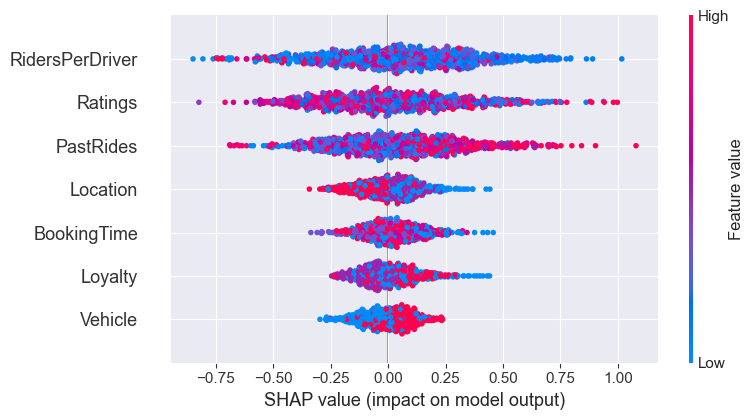

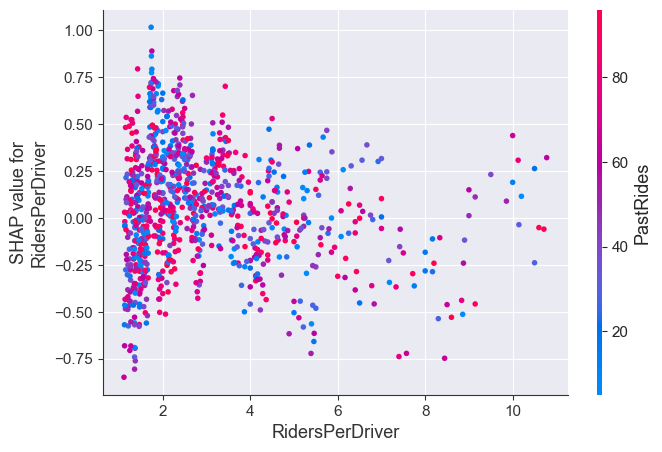

In [82]:
import shap

# Create a SHAP explainer using the trained XGBoost model
explainer = shap.Explainer(xgb_optimal, X)

# Calculate SHAP values for the dataset
shap_values = explainer(X)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, features=X, feature_names=feature_names)

# Plot the SHAP dependence plot for a specific feature, e.g., 'RidersPerDriver'
shap.dependence_plot("RidersPerDriver", shap_values.values, X, feature_names=feature_names)